In [1]:
import pinocchio as pin
import hppfcl
from pinocchio.visualize import MeshcatVisualizer
import meshcat
import numpy as np
from math import cos, sin
from numpy import double
import time
from numpy.linalg import pinv
from scipy.linalg import block_diag, solve
from qpsolvers import solve_qp
from qpsolvers.solvers.proxqp_ import proxqp_solve_qp
import matplotlib.pylab as plt; plt.ion()
import mujoco
import mujoco.viewer

In [2]:
modelfilename = 'test4.xml'
model = pin.buildModelFromMJCF(modelfilename,root_joint=pin.JointModelFreeFlyer())
collision_model = pin.buildGeomFromMJCF(model,modelfilename,pin.GeometryType.COLLISION)
visual_model = pin.buildGeomFromMJCF(model,modelfilename,pin.GeometryType.COLLISION)
data = model.createData()
collision_data = collision_model.createData()
visual_data = visual_model.createData()
model.frames[9].parentJoint = 4
model.frames[10].parentJoint = 4
model.frames[11].parentJoint = 4
model.frames[12].parentJoint = 4
model.frames[19].parentJoint = 7
model.frames[20].parentJoint = 7
model.frames[21].parentJoint = 7
model.frames[22].parentJoint = 7
model.frames[model.getFrameId('t1')].parentFrame = model.getFrameId('link3')
model.frames[model.getFrameId('t2')].parentFrame = model.getFrameId('link3')
model.frames[model.getFrameId('t3')].parentFrame = model.getFrameId('link3')
model.frames[model.getFrameId('t4')].parentFrame = model.getFrameId('link3')
model.frames[model.getFrameId('t5')].parentFrame = model.getFrameId('link6')
model.frames[model.getFrameId('t6')].parentFrame = model.getFrameId('link6')
model.frames[model.getFrameId('t7')].parentFrame = model.getFrameId('link6')
model.frames[model.getFrameId('t8')].parentFrame = model.getFrameId('link6')

In [3]:
class cic1:
    def __init__(self,model,data):
        self.N = 90
        self.dt = 0.01
        self.model = model
        self.data = data
        self.q = pin.neutral(self.model).copy()
        self.q[2] = 1.10
        self.qdot = np.zeros(self.model.nv)
        self.fclist= ['t1','t2','t3','t4','t5','t6','t7','t8']
        self.clist = []
        self.fcN = len(self.fclist)
        self.cN = len(self.clist)
        self.qhist = [self.q]
        self.fhist = []
        self.aqfree = np.zeros(self.model.nv)
        self.M = None
        self.c = None
        self.com = None
        self.Jcom = None
        self.vcom = None
        self.Ag = None
        self.vcom2 = None
        self.vcom3 = None
        self.vcom4 = None
        self.com_task_qobj = None
        self.contactposition = np.zeros(3*self.cN)
        self.contactvelocity = np.zeros(3*self.cN)
        self.Jdv = np.zeros(3*self.cN)
        self.Jdvc = np.zeros(3*self.cN)
        self.o_Jtool = np.zeros((3*self.cN,self.model.nv))
        self.eR = 0.01
        self.Gde = None
        self.tau = None
        self.ttau = np.zeros(self.model.nv-6)

        self.Wtau = np.diag([0.018]*(self.model.nv-6))
        self.jW = None
        self.jWe = 10
        self.jWdiag = None
        self.jlist = None
        self.jN = None
        self.qobj = None
        self.kpj = 100
        self.kdj = 10
        self.ajW = None
        self.ajWe = 10
        self.ajlist = None
        self.ajN = None
        self.aqobj = None

        self.rfpos = None
        self.lfpos = None
        self.rhip = None
        self.lhip = None
        self.fRT = None
        self.fpi = None
        self.fp = None

    def getDK(self):
        model = self.model
        data = self.data
        self.M = pin.crba(model, data, self.q)
        pin.computeMinverse(model,data,self.q)
        self.c = pin.nle(model, data, self.q, self.qdot)
        pin.forwardKinematics(model,data,self.q,self.qdot,np.zeros(model.nv))
        pin.updateFramePlacements(model, data)
        com = pin.centerOfMass(model,data,self.q,self.qdot,False)
        self.com = com
        self.Jcom = pin.jacobianCenterOfMass(model,data,self.q,False)
        self.vcom = self.Jcom@self.qdot
        pin.computeCentroidalMap(model,data,self.q)
        self.Ag = data.Ag
        self.vcom2 = self.Ag[:3,:]@self.qdot
        self.vcom3 = data.vcom[0]
        dt = 0.001
        qnext = pin.integrate(model,self.q,self.qdot*dt)
        comnext = pin.centerOfMass(model,data,qnext,False)
        self.vcom4 = (comnext - com)/dt
        self.com = pin.centerOfMass(model,data,self.q,self.qdot,False)
        rfid = model.getFrameId('link3')
        lfid = model.getFrameId('link6')
        rhid = model.getFrameId('Composite_HIPRY') #Composite_HIPRY
        lhid = model.getFrameId('Composite_HIPLY') #Composite_HIPLY
        self.rfpos = data.oMf[rfid].translation
        self.lfpos = data.oMf[lfid].translation
        self.rhip = data.oMf[rhid].translation
        self.lhip = data.oMf[lhid].translation
        vecr2l = self.lhip - self.rhip
        vecr2lxynorm = np.sqrt(vecr2l[0]*vecr2l[0] + vecr2l[1]*vecr2l[1])
        fRy = np.array([vecr2l[0]/vecr2lxynorm,vecr2l[1]/vecr2lxynorm,0])
        fRz = np.array([0,0,1])
        fRx = np.cross(fRy,fRz)
        self.fRT = np.array([fRx,fRy,fRz])
        self.fp = vecr2l/2 + self.rhip
        self.fpi = -self.fRT@self.fp
        
    def getCon(self):
        model = self.model
        data = self.data
        # self.clist = []
        # fcontactposition = np.zeros(3*self.fcN)
        # for i in range(self.fcN):
        #     fcontactposition[3*i:3*(i+1)] = data.oMf[model.getFrameId(self.fclist[i])].translation
        #     if fcontactposition[3*i+2] < 0:
        #         self.clist.append(self.fclist[i])
        self.cN = len(self.clist)
        self.contactposition = np.zeros(3*self.cN)
        for i in range(self.cN):
            self.contactposition[3*i:3*(i+1)] = data.oMf[model.getFrameId(self.clist[i])].translation
        self.contactvelocity = np.zeros(3*self.cN)
        for i in range(self.cN):
            self.contactvelocity[3*i:3*(i+1)] = pin.getFrameVelocity(model, data, model.getFrameId(self.clist[i]), pin.LOCAL_WORLD_ALIGNED).linear
        self.Jdv = np.zeros(3*self.cN)
        self.Jdvc = np.zeros(3*self.cN)
        for i in range(self.cN):
            self.Jdv[3*i:3*(i+1)] = pin.getFrameAcceleration(model,data,model.getFrameId(self.clist[i]),pin.LOCAL_WORLD_ALIGNED).linear
            self.Jdvc[3*i:3*(i+1)] = pin.getFrameClassicalAcceleration(model, data, model.getFrameId(self.clist[i]), pin.LOCAL_WORLD_ALIGNED).linear
        self.o_Jtool = np.zeros((3*self.cN,model.nv))
        for i in range(self.cN):
            self.o_Jtool[3*i:3*(i+1),:] = pin.computeFrameJacobian(model,data,self.q,model.getFrameId(self.clist[i]), pin.LOCAL_WORLD_ALIGNED)[:3,:]
        # eR = 0.00001
        self.Gde = self.o_Jtool@data.Minv@self.o_Jtool.T + self.eR*np.identity(3*self.cN)

    def tsid(self):
        model = self.model
        data = self.data
        # self.getDK()
        self.getCon()
        if self.jlist is None:
            self.jN = 0
        else:
            self.jN = len(self.jlist)
        self.jW = np.diag([self.jWe]*self.jN)
        if self.jWdiag:
            self.jW = np.diag(self.jWdiag)
        # ratoajw = 1
        # if self.jN>10:
        #     self.jW[4][4]=ratoajw*self.jWe
        #     self.jW[5][5]=ratoajw*self.jWe
        #     self.jW[10][10]=ratoajw*self.jWe
        #     self.jW[11][11]=ratoajw*self.jWe
        if self.ajlist is None:
            self.ajN = 0
        else:
            self.ajN = len(self.ajlist)
        self.ajW = np.diag([self.ajWe]*self.ajN)
        while True:
            self.getCon()
            Pqdd = np.zeros((model.nv+3*self.cN,model.nv+3*self.cN))
            qqdd = np.zeros(model.nv+3*self.cN)
            Jes = np.block([self.M[6:,:],-self.o_Jtool.T[6:,:]])
            esbias = -self.c[6:]
            Pqdd += Jes.T@self.Wtau@Jes
            qqdd += -Jes.T@self.Wtau@esbias
            if self.jN != 0:
                Jj = np.zeros((self.jN,model.nv+3*self.cN))
                for j in range(self.jN):
                    Jj[j,self.jlist[j]] = 1
                qhere = np.array([self.q[i+1] for i in self.jlist])
                qdhere = np.array([self.qdot[i] for i in self.jlist])
                task_ja = -self.kpj*(qhere - self.qobj) - self.kdj*qdhere
                # task_jv = qdhere + task_ja*self.dt
                Pqdd += Jj.T@self.jW@Jj
                qqdd += -(Jj.T)@self.jW@task_ja
            if self.ajN != 0:
                aJj = np.zeros((self.ajN,model.nv+3*self.cN))
                for j in range(self.ajN):
                    aJj[j,self.ajlist[j]] = 1
                task_aja = self.aqobj
                Pqdd += aJj.T@self.ajW@aJj
                qqdd += -(aJj.T)@self.ajW@task_aja
            
            QPP  = Pqdd + 0.001*np.identity(model.nv+3*self.cN)
            QPq = qqdd
            A = np.block([[self.M[:6,:],-self.o_Jtool.T[:6,:]],[self.o_Jtool,0.001*np.identity(3*self.cN)]])
            A[:6,:6] += 0.00001*np.identity(6)
            b = np.concatenate((-self.c[:6],-self.Jdv- 5*(self.contactvelocity)))#- 20*(contactposition - origincontactposition) - 5*(contactvelocity)
            maxset = 100000
            lb = np.array([-maxset]*6+[-15000]*14+[-19000,-19000,-19000]*(self.cN)) #10.1
            ub = np.array([ maxset]*6+[ 15000]*14+[ 19000]*(3*self.cN))
            # self.x = solve_qp(QPP,QPq,A=A,b=b,lb=lb,ub=ub,solver="proxqp").copy()
            self.x = proxqp_solve_qp(QPP,QPq,A=A,b=b,lb=lb,ub=ub,eps_abs=1e-7)
            liftoffstate = 0
            herelist = self.clist.copy()
            for i in range(self.cN):
                if self.clist  and self.x[model.nv+2+3*i] <= -0.00001: #投影到法向
                    herelist.remove(self.clist[i])
                    liftoffstate += 1
            self.clist = herelist
            if liftoffstate == 0:
                break
        self.tau = self.M[6:,:]@self.x[:model.nv] + (self.c[6:]) - self.o_Jtool.T[6:,:]@self.x[model.nv:]

c1 = cic1(model,data)
c1.q = pin.neutral(model).copy()
c1.q[0] = 1.10
# c1.q[1] = 1.10
c1.q[2] = 1.10
# c1.q[3:7] = pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().coeffs()
c1.q[3:7] = pin.Quaternion(pin.AngleAxis(1.5,np.array([0,0,1])).matrix()).coeffs()
c1.qdot = np.zeros(model.nv)
c1.getDK()
# c1.tsid()
c1.tau
print(c1.fRT)
print(c1.rhip)
print(c1.lhip)
print('fpi:',c1.fpi)
print(c1.fp)
T1 = np.block([[c1.fRT.T,c1.fp.reshape(3,1)],[np.array([0,0,0]),1]])
print(T1)
T2 = np.block([[c1.fRT,c1.fpi.reshape(3,1)],[np.array([0,0,0]),1]])
print(T1@T2)

print(c1.rfpos)
print(c1.lfpos)
print(c1.fRT@c1.rfpos+c1.fpi)
print(c1.fRT@c1.lfpos+c1.fpi)

h = 1
g = 9.8
omega = np.sqrt(g/h)
eta = c1.com + c1.vcom/omega
# feta = c1.fRT@eta + c1.fpi
frfpos = c1.fRT@c1.rfpos + c1.fpi
flfpos = c1.fRT@c1.lfpos + c1.fpi
fcom = c1.fRT@c1.com + c1.fpi
fvcom = c1.fRT@c1.vcom
fvp = c1.fRT@(c1.vcom/omega)
feta = fcom + fvp
print('eta:',eta)
print(feta)
print(fcom)
# print(c1.Jcom)
# print(c1.Ag)
# print(c1.vcom2)

[[ 0.0707372   0.99749499 -0.        ]
 [-0.99749499  0.0707372   0.        ]
 [ 0.          0.          1.        ]]
[ 1.24962425 -0.01061058  1.        ]
[0.95037575 0.01061058 1.        ]
fpi: [-0.07781092  1.09724449 -1.        ]
[1.1 0.  1. ]
[[ 0.0707372  -0.99749499  0.          1.1       ]
 [ 0.99749499  0.0707372   0.          0.        ]
 [-0.          0.          1.          1.        ]
 [ 0.          0.          0.          1.        ]]
[[ 1.00000000e+00 -1.36607541e-18  0.00000000e+00 -2.22044605e-16]
 [-1.36607541e-18  1.00000000e+00  0.00000000e+00  3.56834199e-18]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 1.24962425 -0.01061058  0.        ]
[0.95037575 0.01061058 0.        ]
[ 0.   -0.15 -1.  ]
[ 0.    0.15 -1.  ]
eta: [1.1000987  0.00139185 1.12325581]
[0.00139535 0.         0.12325581]
[0.00139535 0.         0.12325581]


In [4]:
aa = pin.AngleAxis(0.1,np.array([0,0,1]))
print(pin.Quaternion(aa.matrix()).coeffs())
print(aa.matrix())
rmatmu = np.zeros(9)
quatmu = np.zeros(4)
mujoco.mju_mat2Quat(quatmu,aa.matrix().flatten())
print(quatmu)

[0.         0.         0.04997917 0.99875026]
[[ 0.99500417 -0.09983342  0.        ]
 [ 0.09983342  0.99500417  0.        ]
 [ 0.          0.          1.        ]]
[0.99875026 0.         0.         0.04997917]


In [ ]:
m = mujoco.MjModel.from_xml_path(modelfilename)
d = mujoco.MjData(m)
mrec = [[] for _ in range(45)]
sinamp = 0.1
c1 = cic1(model,data)
# c1.setCPNL(c1.fclist)
fs = 0
concou = np.zeros(8)
starttime = 0
# ffs = 

def mycontroller(c1,d,ppos):
    c1.q = ppos
    c1.qdot = d.qvel
    global fs
    global concou
    global starttime
    contactstate = 0
    contactstate2 = 0
    rls = 0
    lls = 0
    scst = [0,0]
    c1.getDK()
    h = 1
    g = 9.8
    omega = np.sqrt(g/h)
    mujoco.mj_subtreeVel(m,d)
    c1.vcom = d.subtree_linvel[1]
    eta = c1.com + c1.vcom/omega
    # feta = c1.fRT@eta + c1.fpi
    frfpos = c1.fRT@c1.rfpos + c1.fpi
    flfpos = c1.fRT@c1.lfpos + c1.fpi
    fcom = c1.fRT@c1.com + c1.fpi
    fvcom = c1.fRT@c1.vcom
    # print(c1.vcom)
    # print('fvcom:',fvcom)
    fvp = c1.fRT@(c1.vcom/omega)
    feta = fcom + fvp
    mrec[9].append(eta[1])
    mrec[8].append(c1.vcom[1])
    mrec[10].append(c1.rfpos[0])
    mrec[11].append(c1.lfpos[0])
    mrec[12].append(eta[0])
    mrec[13].append(c1.fpi[1])
    mrec[14].append(feta[1])
    mrec[15].append(feta[0])
    mrec[16].append(frfpos[1])
    mrec[17].append(flfpos[1])
    mrec[18].append(fcom[1])
    mrec[19].append(fcom[2])
    mrec[20].append(fvcom[0])
    mrec[21].append(fvp[0])
    mrec[22].append(c1.vcom[0])
    mrec[27].append(fvcom[1])
    mrec[28].append(c1.com[0])
    mrec[29].append(c1.com[1])
    mrec[33].append(c1.vcom[0])
    mrec[34].append(c1.vcom2[0])
    mrec[35].append(c1.vcom3[0])
    mrec[36].append(c1.vcom4[0])
    if d.sensordata[0]<0.01 and d.sensordata[1]<0.01 and d.sensordata[2]<0.01 and d.sensordata[3]<0.01:
        contactstate +=1
        rls = 1
    #     scst[0] = 1
    #     c1.trl[0] = 0
    # else:
    #     c1.trl[0] = 1
    if d.sensordata[4]<0.01 and d.sensordata[5]<0.01 and d.sensordata[6]<0.01 and d.sensordata[7]<0.01:
        contactstate +=1
        lls = 1
    #     scst[1] = 1
    #     c1.trl[1] = 0
    # else:
    #     c1.trl[1] = 1
    if all(value > 0.01 for value in d.sensordata[:4]):
        contactstate2 += 1
    if all(value > 0.01 for value in d.sensordata[4:8]):
        contactstate2 += 1

    if feta[1]-frfpos[1] > 0.19 and fs == 0: #eta[1] > 0.08 #0.07
        starttime = d.time
        # print(c1.vcom)
        # print('fvcom:',fvcom)
        # print(c1.com)
        # print('fcom:',fcom)
        # print(fvp)
        # print(c1.rfpos)
        # print(c1.lfpos)
        # print(c1.fRT@c1.rfpos+c1.fpi)
        # print(c1.fRT@c1.lfpos+c1.fpi)
        pass
        ###########################################
        print('time:',d.time,'fs_state_transition:0->1')
        fs = 1
    if flfpos[1]-feta[1] > 0.19 and fs == 1: #eta[1] < -0.08
        starttime = d.time
        pass
        ###########################################
        print('time:',d.time,'fs_state_transition:1->0')
        fs = 0

    #knee:0.7 ank:0.12 
    output = 0
    hipyor = 0
    hipyol = 0
    apitr = 0
    apitl = 0
    kneer = 0
    kneel = 0
    hipzr = 0
    hipzl = 0
    kneeliftangle = 0.7 #0.7 #1.5 0.7
    amoo = 0.14 #0.08
    swingang = 0.1
    anklebias = 0.05 #0.08 $0.16 #0.06
    pos2ang = 0.9
    posbias = -0.0 #0也行
    hipb = 0.0 #0.1 0.12
    liftratio = 0
    b = 0.29 #0.2
    # b = 0.2*sin(d.time*2*np.pi/6)+0.25
    # if d.time <4: #4
    #     b = 0.1
    # else:
    #     b = 0.4 #0.4
    mrec[23].append(b)
    if fs == 0:
        # t1.setCPNL(t1.fclist)
        output = -amoo
        kneel = kneeliftangle
        diffpos = fcom[0] + b*fvcom[0] - frfpos[0]#feta[0] - frfpos[0] + posbias
        ang = diffpos#diffpos*pos2ang
        kneel = ang*0 + kneeliftangle
        if lls == 1:
            if abs(diffpos) >= 2:
                print('error!!!!!!')
            ang = np.arcsin(diffpos/2)
            # ang = swingang
            hipyor = ang
            hipyol = -ang
            # hipzr = -0.5
        hipyol += -kneeliftangle/2+hipb+ang*liftratio
        apitl += -anklebias-kneeliftangle/2-ang*liftratio-hipb
        apitr += -anklebias 
        if fvcom[1] > 0:
            kneel = 0
            hipyol += kneeliftangle/2-hipb-ang*liftratio
            apitl += kneeliftangle/2+ang*liftratio+hipb
        pass
    elif fs == 1:
        # t1.setCPNL(t1.fclist)
        output = amoo
        kneer = kneeliftangle
        diffpos = fcom[0] + b*fvcom[0] - flfpos[0]#feta[0] - flfpos[0] + posbias
        ang = diffpos#diffpos*pos2ang
        kneer = ang*0 + kneeliftangle
        if rls == 1:
            if abs(diffpos) >= 2:
                print('error!!!!!!')
            ang = np.arcsin(diffpos/2)
            # ang = swingang
            hipyor = -ang
            hipyol = ang
            # hipzl = 0.5
        hipyor += -kneeliftangle/2+hipb+ang*liftratio
        apitl += -anklebias
        apitr += -anklebias-kneeliftangle/2-ang*liftratio-hipb
        if fvcom[1] < 0:
            kneer = 0
            hipyor += kneeliftangle/2-hipb-ang*liftratio
            apitr += kneeliftangle/2+ang*liftratio+hipb
        pass
    else:
        pass
        # raise ValueError('fs has bad value.')
    
    tclist = []
    for i in range(8): #这里是8！用cN就开始一直是空的了
        if concou[i] > 0.01 :#and contactvelocity[3*i+2] < 0:
            tclist.append(c1.fclist[i])
    c1.clist = tclist
    concou = np.zeros(len(c1.fclist))
    c1.jlist = [6,7,8,9,10,11,              12,13,14,15,16,17,          18,19]
    c1.qobj =  [hipyor,output,hipzr,kneer,apitr,0,   hipyol,output,hipzl,kneel,apitl,0,   0.0,0]
    c1.Wtau[5,5] = 0.1
    c1.Wtau[11,11] = 0.1
    c1.tsid()
    # d.ctrl[:] = c1.tau
    # mrec[24].append(c1.tau[0])
    # mrec[25].append(c1.tau[3])
    # mrec[26].append(c1.tau[4])

def set_cam_viewer(m, viewer):
    # 设置镜头跟随
    viewer.cam.type = mujoco.mjtCamera.mjCAMERA_TRACKING
    viewer.cam.trackbodyid = mujoco.mj_name2id(m, mujoco.mjtObj.mjOBJ_BODY, "link0")
    viewer.cam.distance = 3.0# 设置摄像机距离 
    viewer.cam.elevation = -20# 设置摄像机仰角
    
    # 设置摄像机为固定点模式
    # viewer.cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
    # 设定摄像机的位置和朝向
    # viewer.cam.lookat = [0, 0, 0]  # 摄像机视线的目标点
    # viewer.cam.distance = 5.0      # 摄像机与目标点的距离
    # viewer.cam.elevation = -20     # 摄像机仰角
    # viewer.cam.azimuth = 45        # 摄像机方位角

with mujoco.viewer.launch_passive(m, d) as viewer:
  # set_cam_viewer(m, viewer)
  # Close the viewer automatically after 30 wall-seconds.
  start = time.time()
  ii = 0
  qst = pin.Quaternion(pin.AngleAxis(0,np.array([0,0,1])).matrix()).coeffs().copy()
  qslt = qst[3]
  qst[3] = qst[2]
  qst[2] = qst[1]
  qst[1] = qst[0]
  qst[0] = qslt
  d.qpos[3:7] = qst
  mujoco.mj_forward(m, d)
  while viewer.is_running() and time.time() - start < 25:
    step_start = time.time()
    ppos = d.qpos.copy() # 没有copy就是会修改位置乱动
    quatl = ppos[3]
    ppos[3] = ppos[4]
    ppos[4] = ppos[5]
    ppos[5] = ppos[6]
    ppos[6] = quatl
    for i in range(8):
        concou[i] += d.sensordata[i]

    if ii % 5 == 0:
        mycontroller(c1,d,ppos)
    ii += 1
    c1.ttau -= 0.1*(c1.ttau-c1.tau)
    uot = 120
    lot = -120
    # for i in range(14):
    #     if c1.ttau[i] > uot:
    #         c1.ttau[i] = uot
    #     elif c1.ttau[i] < lot:
    #         c1.ttau[i] = lot
    c1.ttau = c1.tau
    d.ctrl[:] = c1.ttau
    mrec[24].append(c1.ttau[0])
    mrec[25].append(c1.ttau[3])
    mrec[26].append(c1.ttau[4])
    
    # mj_step can be replaced with code that also evaluates
    # a policy and applies a control signal before stepping the physics. 
    mujoco.mj_step(m, d)
    mrec[1].append(d.subtree_com[1][0])
    mrec[2].append(d.subtree_com[1][2])
    mrec[3].append(d.subtree_com[1][1])
    mrec[4].append(sinamp*np.sin(d.time - 2.5)) #这里也要跟着改
    angmomm = np.zeros((3,m.nv))
    mujoco.mj_angmomMat(m,d,angmomm,0)
    hhere = angmomm@d.qvel
    mrec[5].append(hhere[0])
    mrec[6].append(hhere[1])
    mrec[7].append(hhere[2])
    # mrecord8.append(d.qpos[8])
    # mrecord9.append(d.qpos[14])
    mujoco.mj_subtreeVel(m,d)
    mrec[30].append(d.subtree_linvel[1][0])
    mrec[31].append(d.subtree_linvel[1][1])
    mrec[32].append(d.subtree_linvel[1][2])

    # Example modification of a viewer option: toggle contact points every two seconds.
    with viewer.lock():
      viewer.opt.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = int(d.time % 2)

    # Pick up changes to the physics state, apply perturbations, update options from GUI.
    viewer.sync()

    # Rudimentary time keeping, will drift relative to wall clock.
    time_until_next_step = m.opt.timestep - (time.time() - step_start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)

time: 0.08500000000000006 fs_state_transition:0->1
time: 0.3850000000000003 fs_state_transition:1->0
time: 0.7500000000000006 fs_state_transition:0->1
time: 1.0999999999999897 fs_state_transition:1->0
time: 1.4649999999999495 fs_state_transition:0->1
time: 1.849999999999907 fs_state_transition:1->0
time: 2.259999999999862 fs_state_transition:0->1
time: 2.7099999999998126 fs_state_transition:1->0
time: 3.1649999999997624 fs_state_transition:0->1
time: 3.5749999999997173 fs_state_transition:1->0
time: 4.004999999999672 fs_state_transition:0->1
time: 4.459999999999824 fs_state_transition:1->0
time: 4.904999999999973 fs_state_transition:0->1
time: 5.320000000000111 fs_state_transition:1->0
time: 5.770000000000262 fs_state_transition:0->1
time: 6.1800000000003985 fs_state_transition:1->0
time: 6.625000000000547 fs_state_transition:0->1
time: 7.065000000000694 fs_state_transition:1->0
time: 7.500000000000839 fs_state_transition:0->1
time: 7.925000000000981 fs_state_transition:1->0
time: 8.36

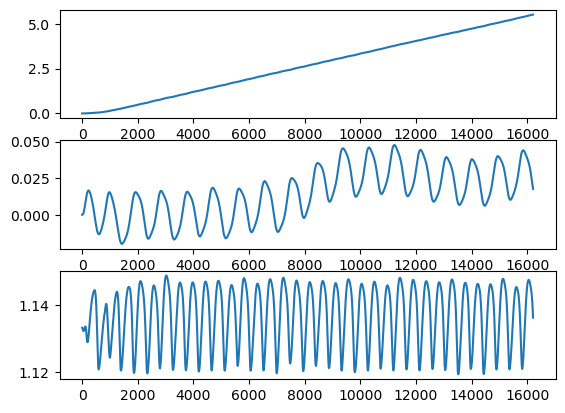

In [29]:
endp = 19000
plt.subplot(311)
plt.plot(mrec[1][:endp])
plt.subplot(312)
plt.plot(mrec[3][:endp])
# plt.plot(mrecord4)
plt.subplot(313)
plt.plot(mrec[2][:endp])

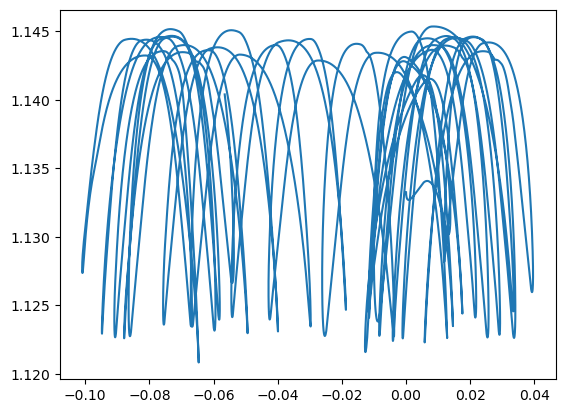

In [33]:
plt.plot(mrec[3][:endp],mrec[2][:endp])

In [ ]:
# mrec[9].append(eta[1])
# mrec[8].append(c1.vcom[1])
# mrec[10].append(c1.rfpos[0])
# mrec[11].append(c1.lfpos[0])
# mrec[12].append(eta[0])
# mrec[13].append(c1.fpi[1])
# mrec[14].append(feta[1])
# mrec[15].append(feta[0])
# mrec[16].append(frfpos[1])
# mrec[17].append(flfpos[1])
# mrec[18].append(fcom[1])
# mrec[19].append(fcom[2])
# mrec[20].append(fvcom[0])
# mrec[21].append(fvp[0])
# mrec[22].append(c1.vcom[0])

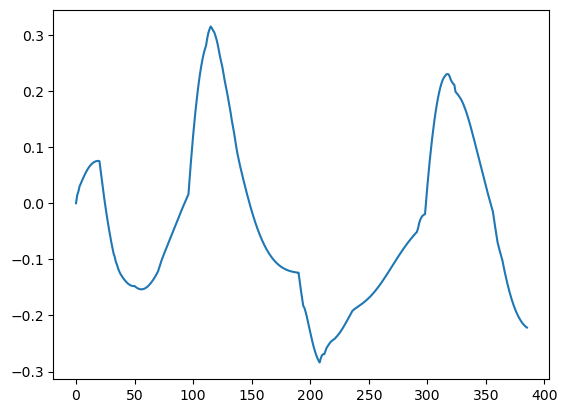

In [119]:
plt.plot(mrec[36][:endp])

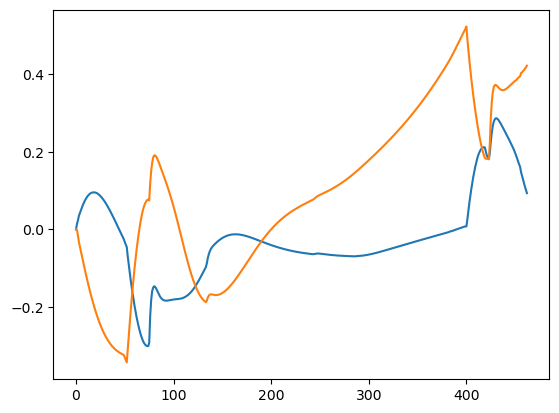

In [68]:
plt.plot(mrec[33][:endp])
plt.plot(mrec[8][:endp])

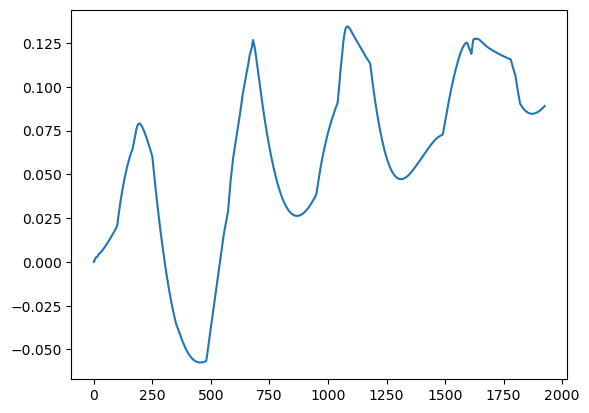

In [120]:
# plt.plot(mrec[30][:endp])
plt.plot(mrec[31][:endp])
# plt.plot(mrec[32][:endp])

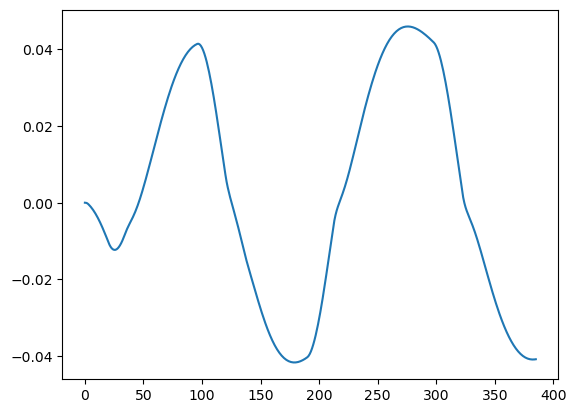

In [122]:
plt.plot(mrec[18][:endp])

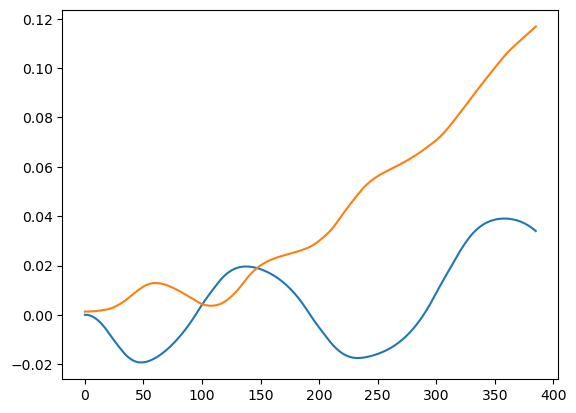

In [121]:
plt.plot(mrec[28][:endp])
plt.plot(mrec[29][:endp])
# plt.plot(mrec[27][:endp])

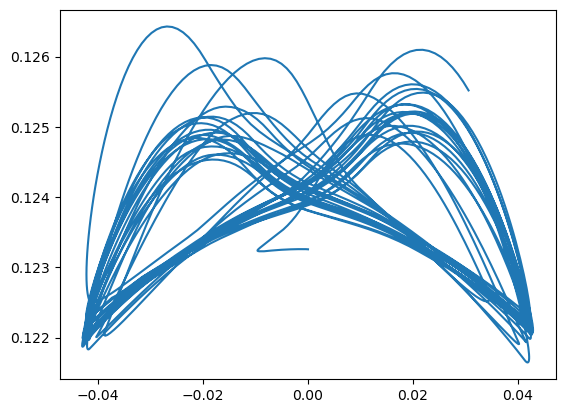

In [34]:
plt.plot(mrec[18][:endp],mrec[19][:endp])

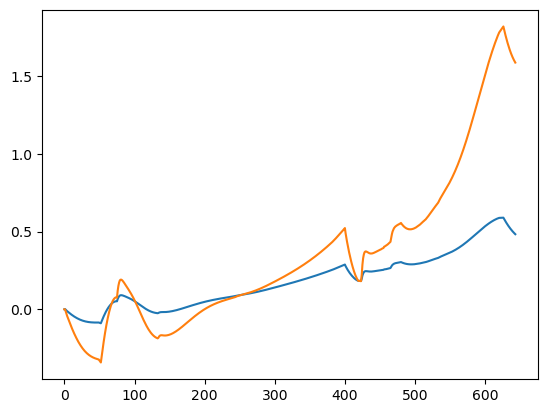

In [35]:
plt.plot(mrec[9][:endp])
plt.plot(mrec[8][:endp])
# plt.plot(mrec[3][:endp:5])

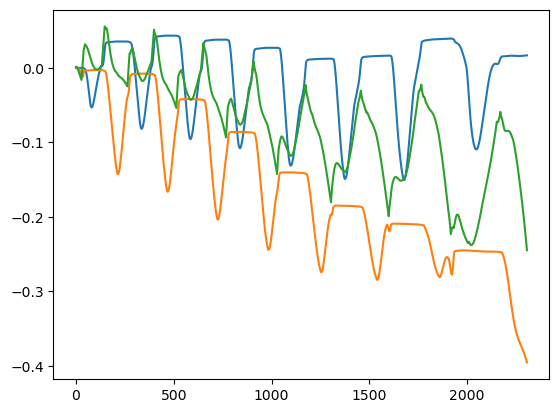

In [9]:
plt.plot(mrec[10][:endp])
plt.plot(mrec[11][:endp])
plt.plot(mrec[12][:endp])

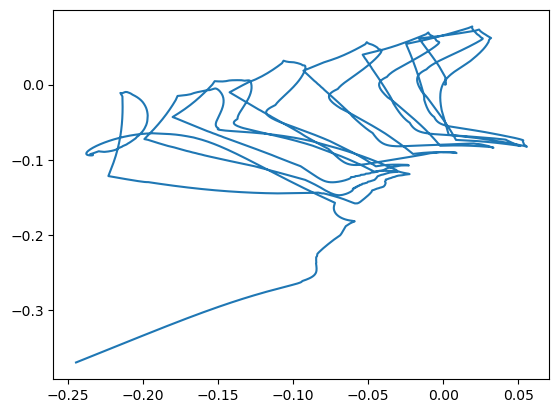

In [10]:
plt.plot(mrec[12][:endp],mrec[9][:endp])

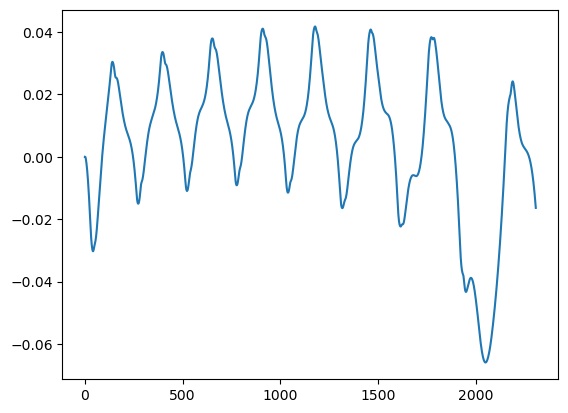

In [11]:
plt.plot(mrec[13][:endp])
# plt.plot(mrec[14][:endp])
# plt.plot(mrec[15][:endp])

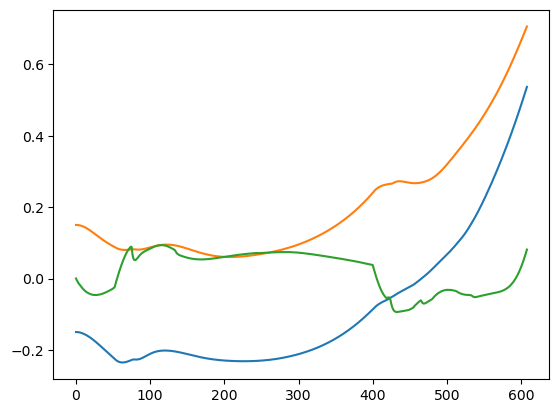

In [38]:
plt.plot(mrec[16][:endp])
plt.plot(mrec[17][:endp])
plt.plot(mrec[14][:endp])

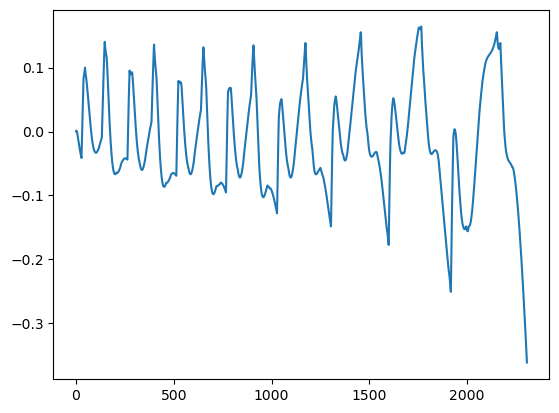

In [13]:
plt.plot(mrec[20][:endp])
# plt.plot(mrec[21][:endp])

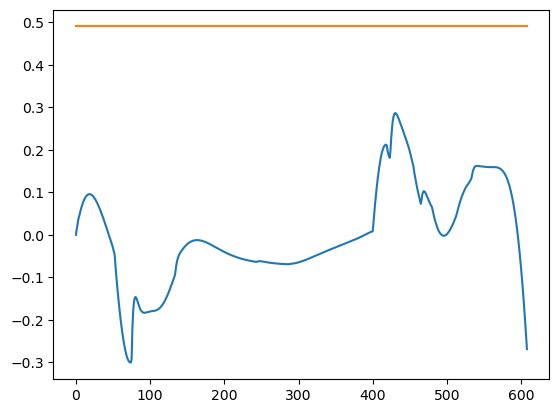

In [39]:
plt.plot(mrec[22][:endp])
plt.plot(mrec[23][:endp])

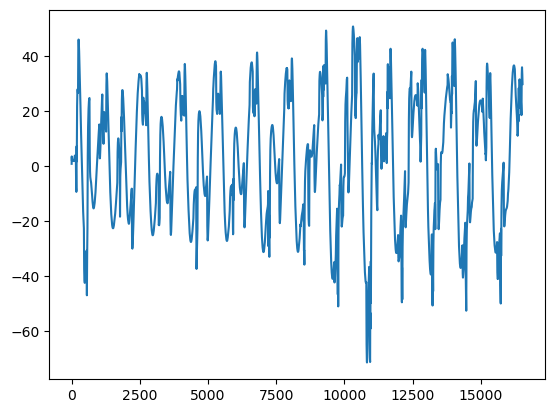

In [11]:
plt.plot(mrec[24][:endp])

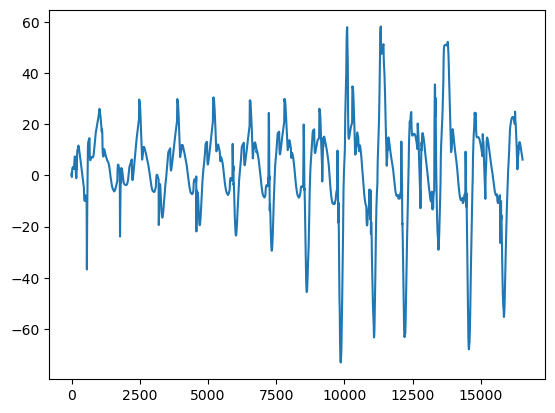

In [12]:
plt.plot(mrec[25][:endp])

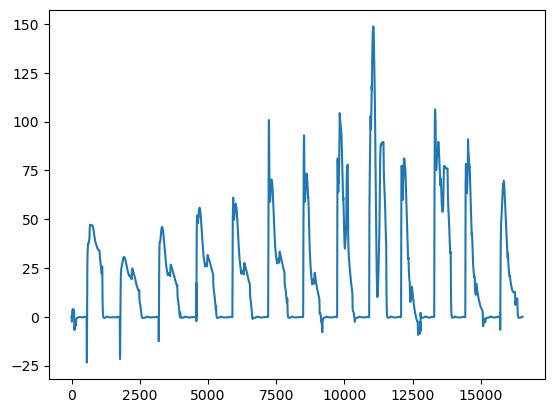

In [13]:
plt.plot(mrec[26][:endp])

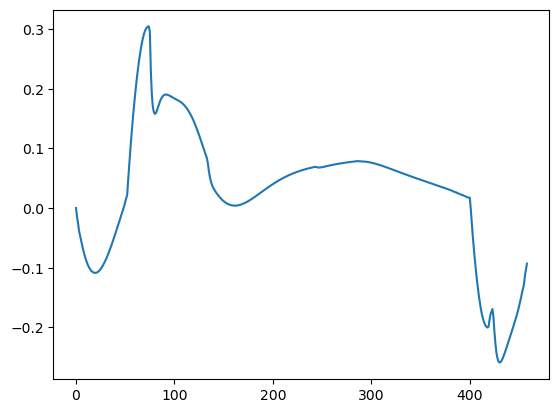

In [49]:
plt.plot(mrec[27][:endp])